#### Load required libraries

In [1]:
import numpy as np
import logging
import pickle
from scipy import sparse
from scipy.linalg import block_diag
import scipy.io as spio

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

#import os.path
import os
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SH_AcO'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

In [2]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

In [3]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)

<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

#### Load Active optics relevant data

In [4]:
# Calibrations data
#dt = np.load(Path(calibDataFolder)/'calib_dt_SH0p5fluxTH_46BM.npz', allow_pickle=True)
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)

# Relative RBM:BM weighting
norm_RBM = np.linalg.norm(dt['calibdt'][()]['D'][0][:,:12])
norm_BM = np.linalg.norm(dt['calibdt'][()]['D'][0][:,12:])
print('Ratio ||BM||/||RBM||:',norm_BM/norm_RBM)
# M1:M2 
norm_Dm1 = np.linalg.norm(dt['calibdt'][()]['D'][0][:,:6])
norm_Dm2 = np.linalg.norm(dt['calibdt'][()]['D'][0][:,6:12])
print('Ratio ||D_m1||/||D_m2||:%0.3g'%(norm_Dm1/norm_Dm2))

Ratio ||BM||/||RBM||: 0.057479135047774646
Ratio ||D_m1||/||D_m2||:7.77


In [21]:
def get_aco_recW(Dsh,n_bm,max_m1RBM,max_m2RBM):
    
    # --- W2 ---
    _U,sigma,VT = np.linalg.svd(Dsh,full_matrices=False)
    q = 40*sigma[-12:] #np.ones((12)) #np.zeros_like(sigma)
    W2 = VT[-12:,:].T.dot(np.diag(q)).dot(VT[-12:,:])

    # --- W3 ---
    rho_bm = 1.0 #0.1

    W_M1TxyzRxyz = 1/np.array(max_m1RBM)
    W_M2TxyzRxyz = 1/np.array(max_m2RBM)
    W_rbm_oa = block_diag(np.diag(W_M1TxyzRxyz), np.diag(W_M2TxyzRxyz))
    W_rbm_cs = block_diag(np.diag(W_M1TxyzRxyz[:-1]), np.diag(W_M2TxyzRxyz[:-1]))
    # Rescale RBM weighting matrix
    W_rbm_oa = (1/np.linalg.norm(W_rbm_oa))*W_rbm_oa
    W_rbm_cs = (1/np.linalg.norm(W_rbm_cs))*W_rbm_cs

    # OA segment weights
    W_m1oaBM = np.diag([1]*n_bm) #np.diag(1/s[:n_bm])
    W_m1oaBM =  rho_bm*(1/np.linalg.norm(W_m1oaBM))*W_m1oaBM
    # CS (center segment) weights
    W_m1csBM = np.diag([1]*n_bm) #np.diag(1/s[:n_bm])
    W_m1csBM =  rho_bm*(1/np.linalg.norm(W_m1csBM))*W_m1csBM

    W3_oa = block_diag(W_rbm_oa,W_m1oaBM)
    W3_cs = block_diag(W_rbm_cs,W_m1csBM)
    W3 = block_diag(np.kron(np.eye(6),W3_oa),W3_cs)
    sens_D = np.linalg.norm(Dsh, axis=0)
    W3 = (1/np.linalg.norm(W3))*W3 #(W3.dot(np.diag(sens_D)))
    
    return W2, W3



In [22]:
Dk = dt['calibdt'][()]['D'][0]
a,b,c,d,e = np.split(np.linalg.norm(Dk, axis=0),[3,6,9,12])
a,b,c,d

(array([1.20399152, 1.17316789, 0.32551305]),
 array([46.1102211 , 44.81211394,  0.20569824]),
 array([1.31526888, 1.2871706 , 0.28734078]),
 array([5.77226239, 5.63262385, 0.02362541]))

In [23]:
Dk = dt['calibdt'][()]['D'][6]
a,b,c,d,e = np.split(np.linalg.norm(Dk, axis=0),[3,5,8,10])
a,b,c,d

(array([1.18001666, 1.17984574, 0.19805011]),
 array([42.77732999, 42.7804449 ]),
 array([1.28351287, 1.28334167, 0.19945684]),
 array([5.37593404, 5.37632806]))

#### AcO reconstructor+controller settings

In [49]:
# *** Reconstructor tuning settings ***

# Number of bending modes
n_bm = 27

# Consolidate SH-WFS interaction matrices of all segments
Dsh = block_diag(*[Dseg[:,:12+n_bm] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dsh = block_diag(Dsh,dt['calibdt'][()]['D'][-1][:,:10+n_bm])

# Max actuator command values
max_m1RBM = [3.0e-3,4.75e-3,4e-3] + [6.5e-4,5.75e-4,5.75e-4]
max_m2RBM = [3.0e-5,3.0e-5,3.0e-5] + [3.5e-3,3.5e-3,3.5e-3]
W2,W3 = get_aco_recW(Dsh,n_bm,max_m1RBM,max_m2RBM)

max_Fz = 147
K, rho_2, rho_3 = 0.25, 1.0, 1.0e-2

# Print reconstructor regularization weights
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
w__, _w_,__w = np.split(np.diag(W3),[12,39])
print('OA BM weights:\n',_w_)
print('M1/2 RBM weights (M1/TxyzRxyz - M2/TxyzRxyz):\n',w__)
np.set_printoptions(formatter=None)


# *** Controller settings ****

# Plant dynamic model matrices
A = np.zeros((84+7*n_bm,84+7*n_bm))
B = np.identity(84+7*n_bm)
nx, nu = A.shape[0], B.shape[1]

# Prediction horizon
npred = 4
# Weighting matrices
Q = np.eye(nx)
R = 8*np.kron(np.eye(7),block_diag(np.diag(np.array([1]*6)),
                                   np.diag(np.array([1]*6)),
                                   np.diag(np.array([1]*n_bm))))
print(np.linalg.norm(Q),np.linalg.norm(R))

# Bending modes' data
Afz = {}

# OA segment weights
filepath = os.path.join('../ActiveOptics','Af_oa_axial_ver3.mat')
Afz['outer'] = spio.loadmat(filepath)['afprime']
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
# CS (center segment) weights
filepath = os.path.join('../ActiveOptics','Af_cs154_axial.mat')
Afz['center'] = spio.loadmat(filepath)['afprime']
_U,s_cs,V_csT = np.linalg.svd(Afz['center'],0)
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])

rbm_ranges = max_m1RBM+max_m2RBM
#oa_ranges = np.array(rbm_ranges + [max_Fz/np.linalg.norm(bm2Fz_oa)]*bm2Fz_oa.shape[0])
#cs_ranges = np.array(rbm_ranges + [max_Fz/np.linalg.norm(bm2Fz_cs)]*bm2Fz_cs.shape[0])
oa_ranges = np.array(rbm_ranges + [max_Fz]*bm2Fz_oa.shape[0])
cs_ranges = np.array(rbm_ranges + [max_Fz]*bm2Fz_cs.shape[0])

umax = np.array([]) # np.hstack([np.kron(np.array([1]*6),oa_ranges),cs_ranges]) #  
umin = -umax
_Tu = block_diag(np.kron(np.eye(6),block_diag(np.eye(12),bm2Fz_oa)),
                 block_diag(np.eye(12),bm2Fz_cs))

# AcO dictionary
data = {'SHAcO':{'D':Dsh,'n_bm':n_bm,'W2':W2,'W3':0.0*W3,
                 'K':K,'rho_2':rho_2,'rho_3':rho_3,
                 'wfsMask':dt['calibdt'][()]['wfsMask'],
                 'A':A,'B':B,
                 'Q':sparse.csc_matrix(Q),'R':sparse.csc_matrix(R),'npred':npred,
                 'umin':umin, 'umax':umax,'_Tu':_Tu}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO.pickle','wb') as f:
    pickle.dump(data,f)
    

OA BM weights:
 [ 0.051434  0.051434  0.051434  0.051434  0.051434  0.051434  0.051434
  0.051434  0.051434  0.051434  0.051434  0.051434  0.051434  0.051434
  0.051434  0.051434  0.051434  0.051434  0.051434  0.051434  0.051434
  0.051434  0.051434  0.051434  0.051434  0.051434  0.051434]
M1/2 RBM weights (M1/TxyzRxyz - M2/TxyzRxyz):
 [ 0.001541  0.000973  0.001156  0.007112  0.008040  0.008040  0.154098
  0.154098  0.154098  0.001321  0.001321  0.001321]
16.522711641858304 132.18169313486644


In [39]:
# # Check reconstructors 
# M_rls = dos.tools.build_RLS_RecM(Dsh, W2, W3=1.0e-3*W3, K=K, rho_2=np.sqrt(1), rho_3=rho_3, insM1M2S7Rz=True)
# M_rls = M_rls[:,:-273]
# M_tsvd = dos.tools.build_TSVD_RecM(Dsh, n_r=12, insM1M2S7Rz=True)
# M = dos.tools.build_AcO_Rec(dt['calibdt'][()]['D'],n_bm=n_bm,rec_alg='TSVD')
# print(np.linalg.norm(M_rls-M), np.linalg.norm(M_tsvd-M))

# dt1 = np.diag(M_rls.dot(M_rls.T))[:39]
# dt2 = np.diag(M_tsvd.dot(M_tsvd.T))[:39]
# dt3 = np.diag(M.dot(M.T))[:39]
# plt.figure(figsize=(16,6))
# #plt.plot(100*np.abs(dt3-dt1)/dt3,'s')
# #plt.plot(100*np.abs(dt3-dt2)/dt3,'+')
# plt.semilogy(dt1,'s')
# plt.semilogy(dt2,'.')
# plt.semilogy(dt3,'x')

#### Set initial M1/M2 states and generate respective yaml files

In [40]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML

# ----- Flag to control if simulation initial state is updated -----
updateX0 = False

test_case = 'random_RBM' #'BM_dist'

# Initialize states dictionary
if 'm1_x0_dt' not in locals():
    m1_x0_dt = {'mirror' : 'M1',
                'mirror_args': {'mirror_modes': 'bending modes','N_MODE': n_bm},
                'state': {'Txyz':[],'Rxyz':[],'modes':[]}}
if 'm2_x0_dt' not in locals():
    m2_x0_dt = {'mirror' : 'M2',
                'mirror_args': {},
                'state': {'Txyz':[],'Rxyz':[]}}

m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()        
# Update number of M1 bending modes in yaml file
m1_x0_dt['mirror_args']['N_MODE'] = n_bm
        
if(test_case == 'fully_aligned'):
    pass

#        
elif(test_case == 'BM_dist'):
    m1_x0_dt['state']['modes'][0][2] = 5.0e-4
    m1_x0_dt['state']['modes'][0][1] = 5.0e-4
    
#    
elif(test_case == 'random_RBM') and updateX0:
    k_ = 3.0e-6    # 3xstd
    as2urad = 4.84814
    x_rand = (2*np.random.rand(7,39)-1)
    # M1 random initial values
    x0_M1_Tx = k_*block_diag(np.kron(np.eye(6),0.057),1.654).dot(x_rand[:,0])
    x0_M1_Ty = k_*block_diag(np.kron(np.eye(6),0.06),0.99).dot(x_rand[:,1])
    x0_M1_Tz = k_*block_diag(np.kron(np.eye(6),0.144),0.201).dot(x_rand[:,2])
    m1_x0_dt['state']['Txyz'] = np.vstack([x0_M1_Tx,x0_M1_Ty,x0_M1_Tz]).T.tolist()
    x0_M1_Rx = k_*as2urad*block_diag(np.kron(np.eye(6),0.01),0.014).dot(x_rand[:,3])
    x0_M1_Ry = k_*as2urad*block_diag(np.kron(np.eye(6),0.004),0.016).dot(x_rand[:,4])
    x0_M1_Rz = k_*as2urad*block_diag(np.kron(np.eye(6),0.006),0.035).dot(x_rand[:,5])
    m1_x0_dt['state']['Rxyz'] = np.vstack([x0_M1_Rx,x0_M1_Ry,x0_M1_Rz]).T.tolist()
    #x0_BM = 0.0*k_states*4e-6*(2*np.random.rand(7,n_bm)-1)
    # M2 random initial values
    x0_M2_Tx = k_*block_diag(np.kron(np.eye(6),6.235),5.863).dot(x_rand[:,6])
    x0_M2_Ty = k_*block_diag(np.kron(np.eye(6),6.192),5.863).dot(x_rand[:,7])
    x0_M2_Tz = k_*block_diag(np.kron(np.eye(6),1.595),0.869).dot(x_rand[:,8])
    m2_x0_dt['state']['Txyz'] = np.vstack([x0_M2_Tx,x0_M2_Ty,x0_M2_Tz]).T.tolist()
    x0_M2_Rx = k_*as2urad*block_diag(np.kron(np.eye(6),0.474),0.463).dot(x_rand[:,9])
    x0_M2_Ry = k_*as2urad*block_diag(np.kron(np.eye(6),0.688),0.465).dot(x_rand[:,10])
    x0_M2_Rz = k_*as2urad*block_diag(np.kron(np.eye(6),2.315),2.186).dot(x_rand[:,11])
    m2_x0_dt['state']['Rxyz'] = np.vstack([x0_M2_Rx,x0_M2_Ry,x0_M2_Rz]).T.tolist()

if updateX0:
    # Update yaml files with M1/M2 initial conditions    
    with open(Path(sim_folder)/'M1.yaml','w') as f:
            y.dump(m1_x0_dt, f)
    with open(Path(sim_folder)/'M2.yaml','w') as f:
            y.dump(m2_x0_dt, f)
else:
    with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

#### Instantiate DOS

In [50]:
sim = dos.DOS(sim_folder,verbose=logging.WARNING,show_timing=2)

INFO:wfs48 data:Linked to data from wfs48
INFO:M1 Txyz:Linked to Txyz from M1
INFO:M1 Rxyz:Linked to Rxyz from M1
INFO:M2 Txyz:Linked to Txyz from M2
INFO:M2 Rxyz:Linked to Rxyz from M2
INFO:M1 BM:Linked to modes from M1


SIMCEO server received: Acknowledging connection from SIMCEO client!
27 BMs used in the reconstructor computation.
No constraints introduced to the MPC


In [51]:
# Start simulation
#sim.start()
sim._run_()

Elapsed time: 28.856072902679443


In [9]:
sim.pctComplete

100

### Image quality metrics

In [10]:
sim.logs

The 'logs' has 12 entries:
 * wfs48
   1. M12_RBM: (273,)x50
 * SHAcO
   1. M1 Txyz: (7, 3)x50
   2. M1 Rxyz: (7, 3)x50
   3. M2 Txyz: (7, 3)x50
   4. M2 Rxyz: (7, 3)x50
   5. M1 BM: (7, 27)x50
 * science
   1. wfe_rms: (1,)x50
   2. segment_wfe_rms: (7,)x50
   3. PSSn: (1,)x50
   4. tiptilt: (2,)x50
   5. segment_piston: (7,)x50
   6. segment_tiptilt: (14,)x50

In [8]:
sim.logs.entries['science']['wfe_rms'].timeSeries[1][0,:]*1.0e9

array([5658.20528209])

In [9]:
sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]

array([3.62973901e-06, 4.60628326e-06, 3.52569077e-06, 3.27596535e-06,
       3.33221101e-06, 7.87937950e-07, 4.53212215e-06])

 #### Baseline reconstructor & Integral without saturation


Final values:
 WFE (nm): [1.00681552] 
 [0.76922274 0.77474599 0.77488654 0.77061335 0.77744144 0.77117146
 0.17256181] 
PSSn: [0.99999991] 
sum of abs seg piston (um): 0.007327963513770186 
 [-0.00216886 -0.00094285 -0.00019296 -0.00200792 -0.00084521 -0.0006616
 -0.00050857]


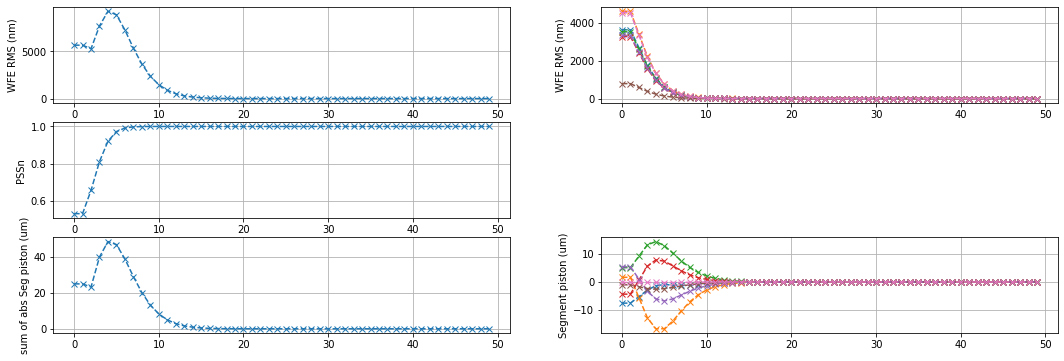

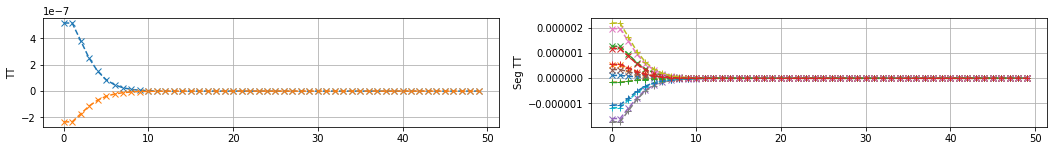

In [52]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE (nm): [1.55037561] 
 [0.77195667 0.77259227 0.7725755  0.77205259 0.77249956 0.7717591
 0.17243233] 
PSSn: [0.99999984] 
sum of abs seg piston (um): 0.007151944023120471 
 [ 2.89422286e-03 -3.63172381e-04 -3.05062309e-04  2.86273583e-03
  3.04024861e-05 -2.23896193e-04  4.72451966e-04]


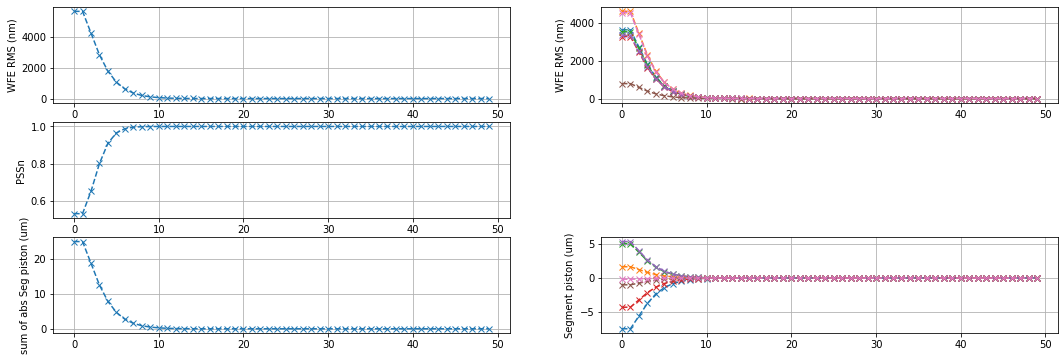

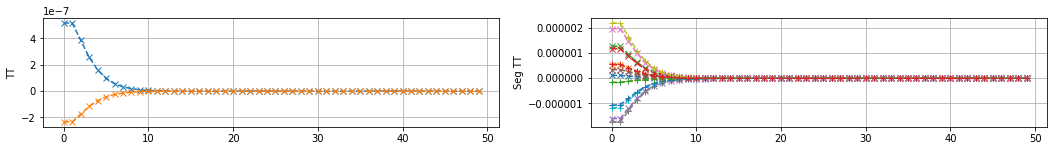

In [43]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 #### Regularized reconstructor ($\rho = \frac{1}{20}$) & Integral controller without saturation


Final values:
 WFE (nm): [1.01208897] 
 [0.7693336  0.77498025 0.77468598 0.77053092 0.77757506 0.77105478
 0.17256745] 
PSSn: [0.99999982] 
sum of abs seg piston (um): 0.007493376280587327 
 [-0.00217748 -0.0009494  -0.00027845 -0.00207176 -0.00096404 -0.00060301
 -0.00044924]


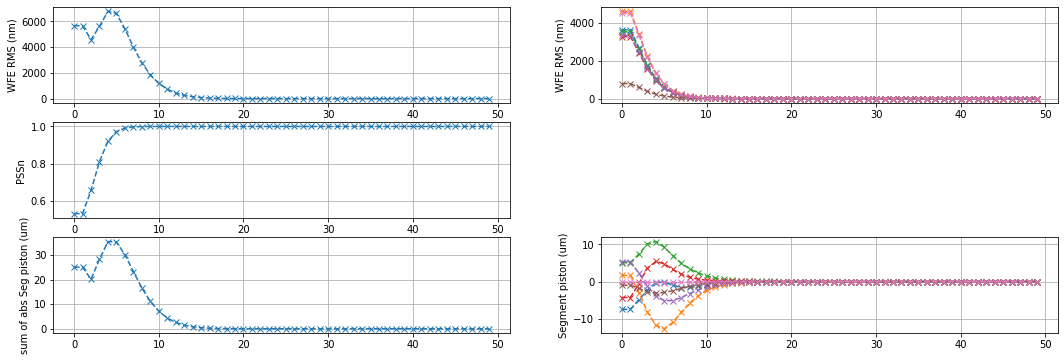

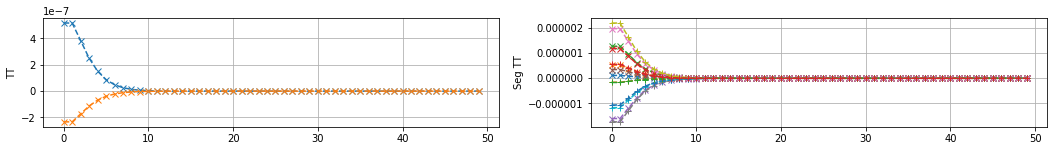

In [29]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE (nm): [1.54349922] 
 [0.77194978 0.77261275 0.77255918 0.77203943 0.77251355 0.77173629
 0.17243232] 
PSSn: [0.99999994] 
sum of abs seg piston (um): 0.00709352094077631 
 [ 2.87479063e-03 -3.36386280e-04 -2.58166155e-04  2.87581137e-03
  3.43333174e-05 -2.45596460e-04  4.68436734e-04]


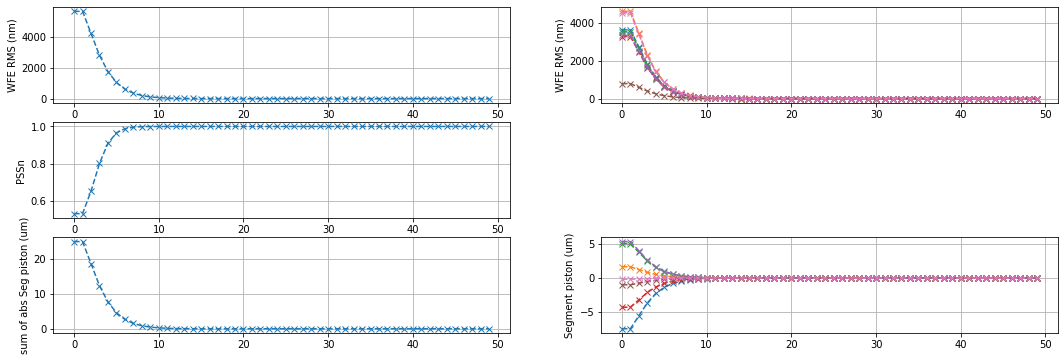

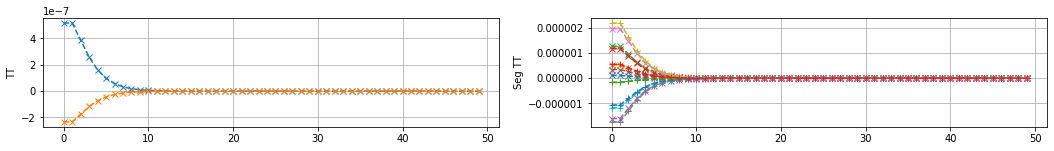

In [37]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

### Controller outputs and aberration inducing loads

 #### Baseline reconstructor & Integral without saturation

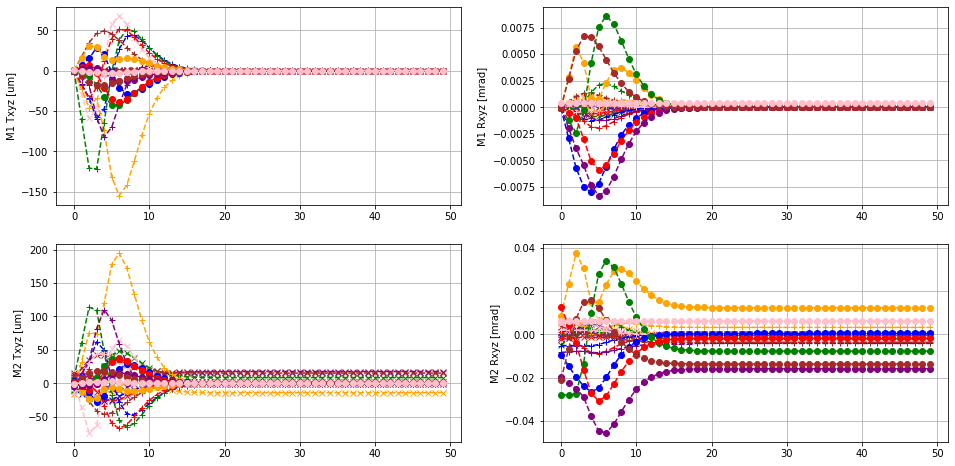

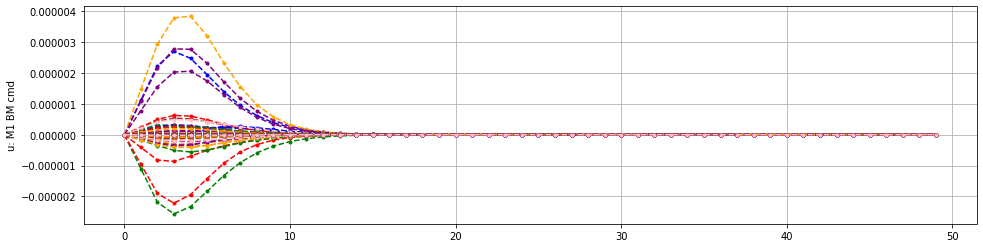

In [53]:
U = sim.logs.entries['SHAcO']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

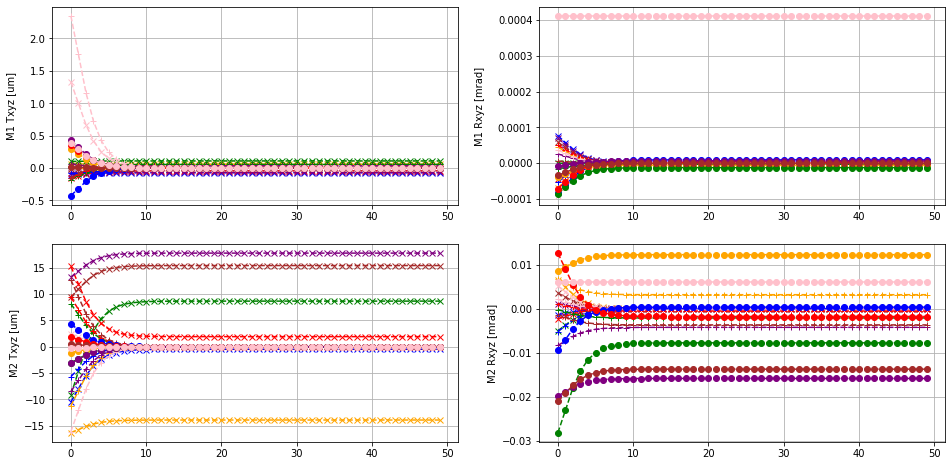

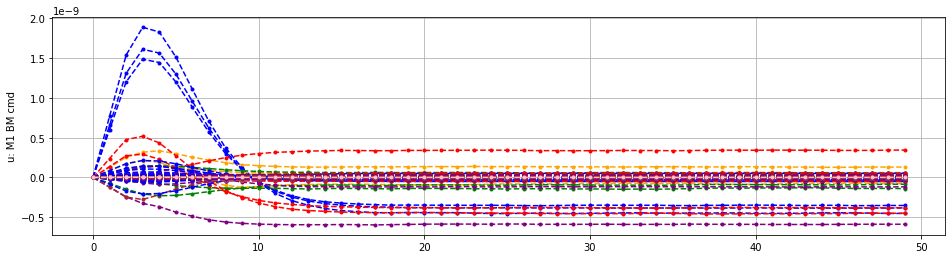

In [44]:
U = sim.logs.entries['SHAcO']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### Regularized reconstructor ($\rho = \frac{1}{20}$) & Integral controller without saturation

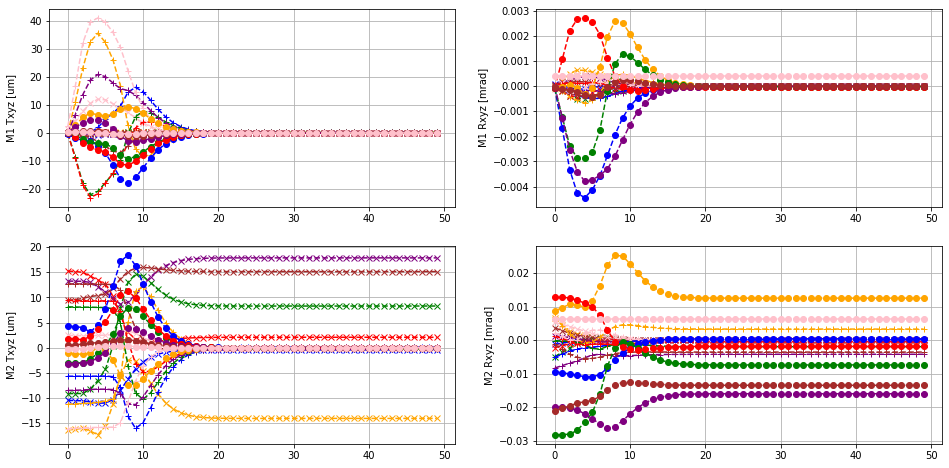

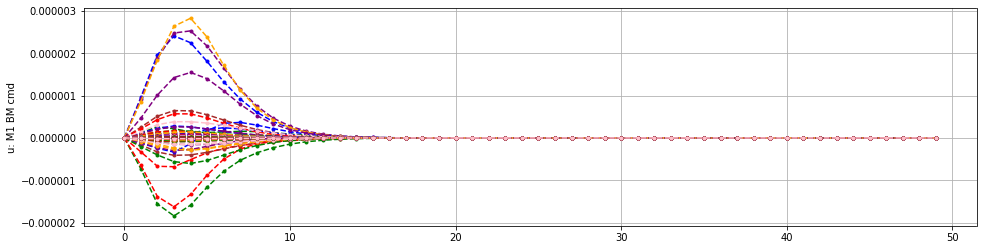

In [32]:
U = sim.logs.entries['SHAcO']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

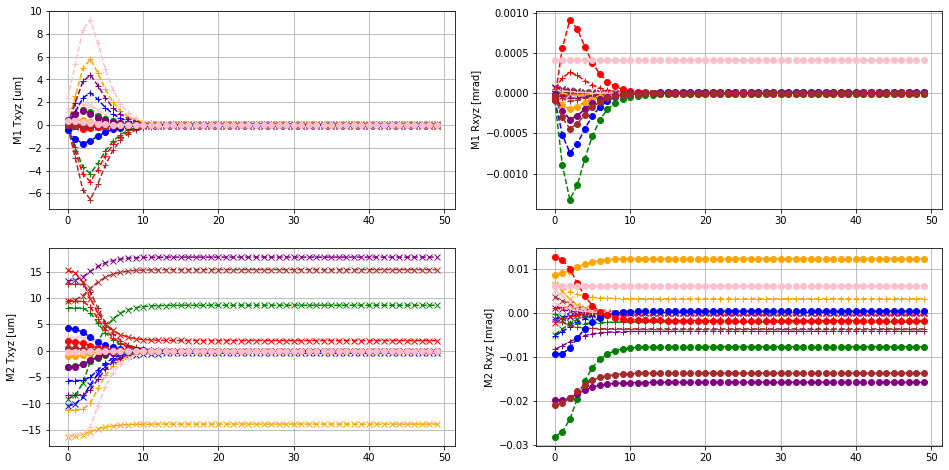

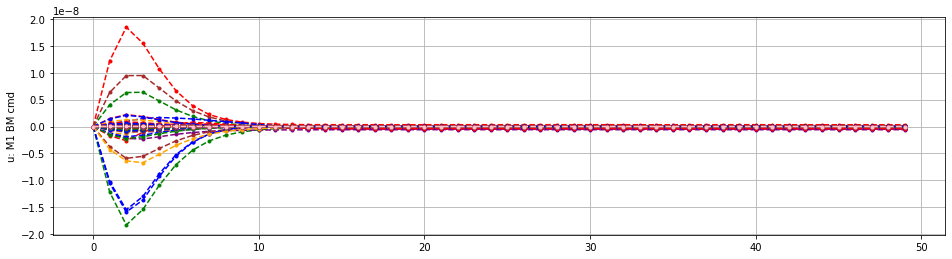

In [36]:
U = sim.logs.entries['SHAcO']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### Regularized reconstructor & MPC with saturation

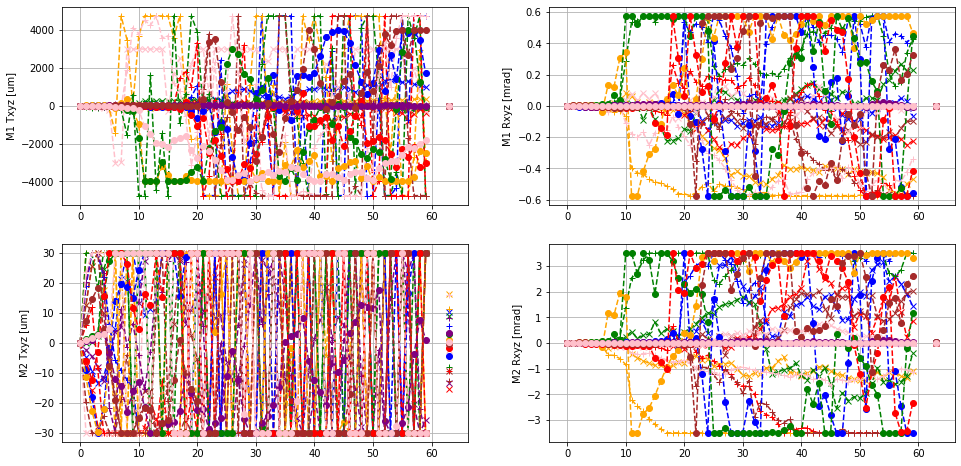

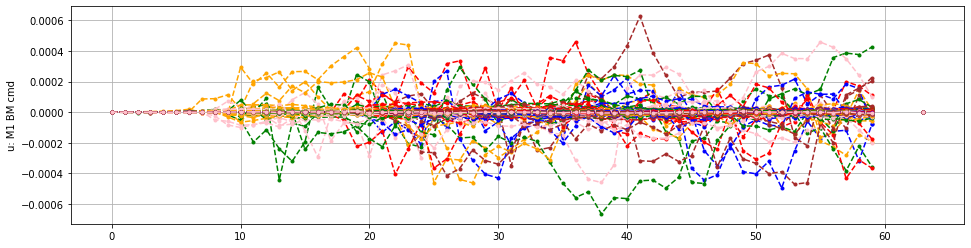

In [61]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

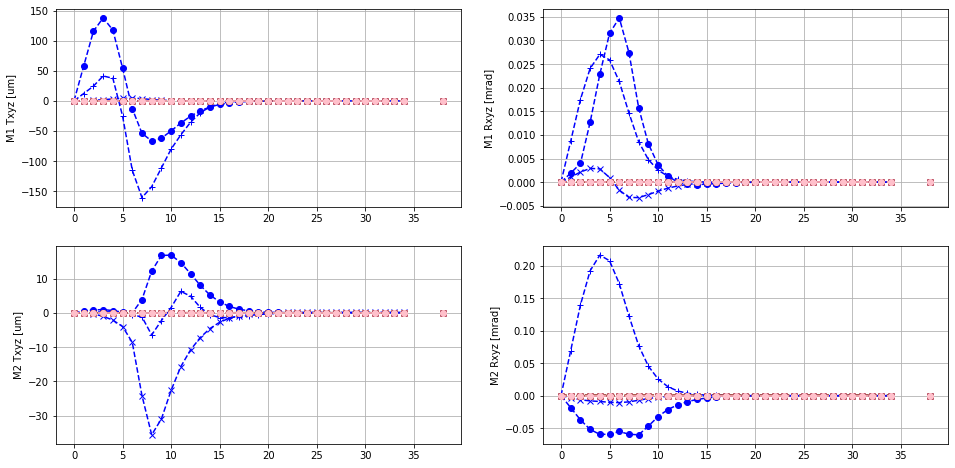

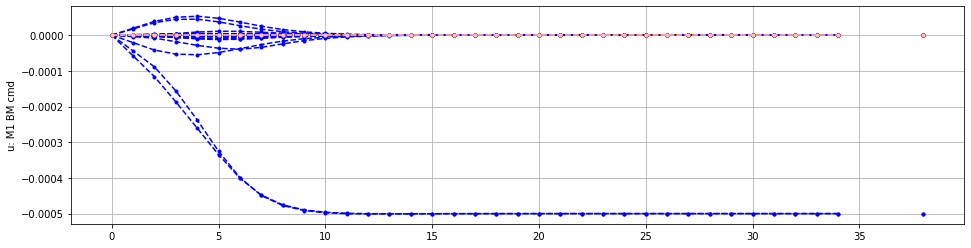

In [9]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

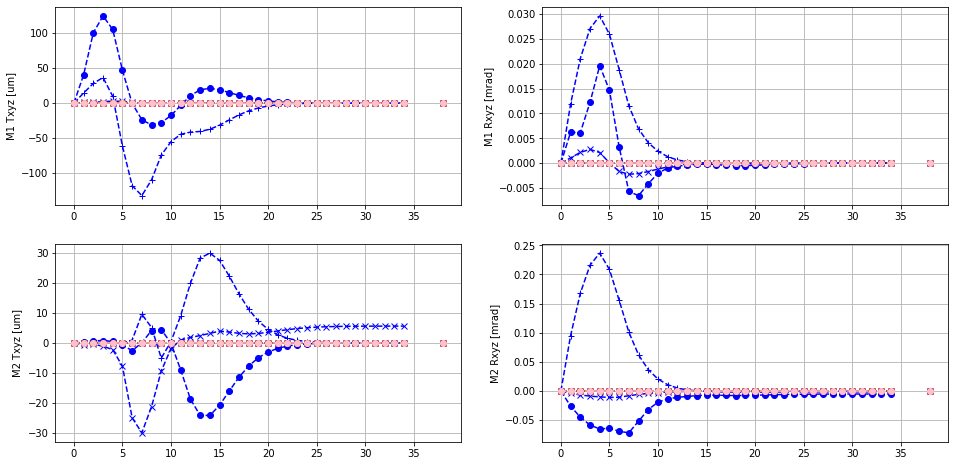

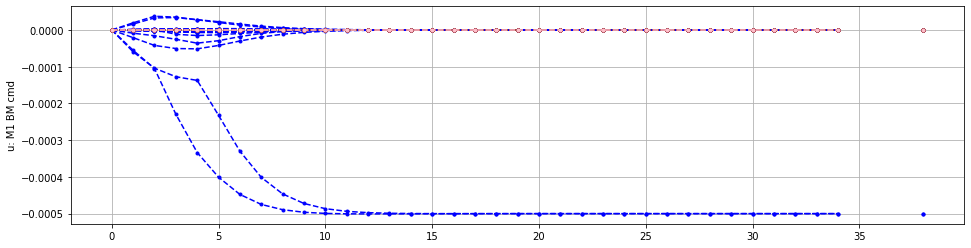

In [9]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

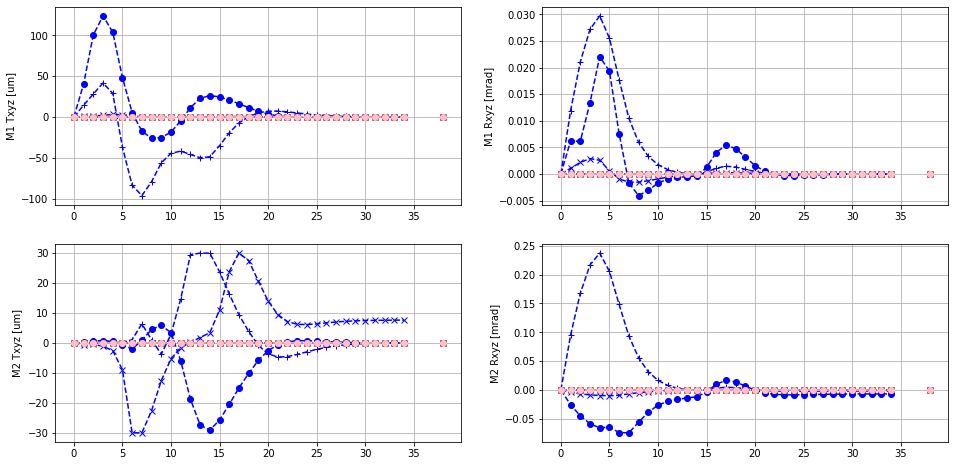

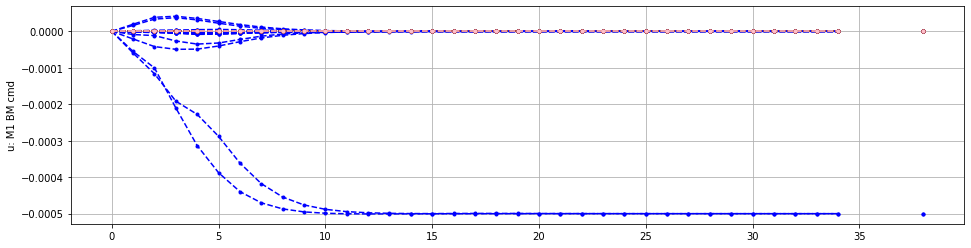

In [8]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [11]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

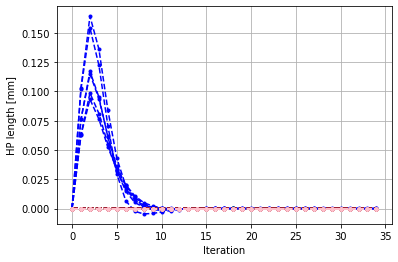

In [12]:
U = sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

In [79]:
3.5e-6*(180/np.pi)*3600

0.7219268218648373

In [103]:
# Test cases in which REQ-L4-M1S-51833 seems misleading, according 
#to the CG2HP matrix of build3 fem
M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,650e-6,575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,0*650e-6,0*575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

HP lengths [ 6.15074717  2.42595625  2.38654281  5.98007822  3.34834477 -3.78004005]
HP lengths [ 7.96706706  2.71784883  1.4437542   4.29725283  2.50323777 -2.38093131]


In [98]:
np.array([[0.38, 40],[3, 330]])/3600*(np.pi/180)

array([[1.84229199e-06, 1.93925472e-04],
       [1.45444104e-05, 1.59988515e-03]])

#### Reconstructed states

 #### MPC w/o saturation

 #### Baseline reconstructor MPC with saturation

In [ ]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

 #### Regularized reconstructor & MPC with saturation

#### Clutter

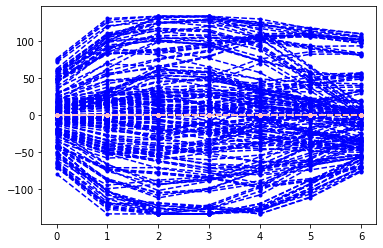

In [14]:
import matplotlib.pyplot as plt

BM = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM[1][kseg,:,1:8]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM[1][6,:,1:8]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM[0].shape),'k')
plt.show()

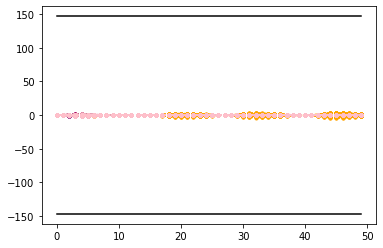

In [20]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0].shape),'k')
plt.show()

In [91]:
#U_sat.shape, Fz2bm.shape, bm_sat.shape
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
isigma = np.zeros_like(s_oa)
n_bm = 27
isigma[:n_bm] = 1/s_oa[:n_bm]

T1 = np.dot(V_oaT.T, np.diag(isigma))
T2 = np.dot(np.diag(s_oa),V_oaT)
print('norm of I-T1*T2: %0.4g'%np.linalg.norm(np.eye(165)-T1.dot(T2)))

U_ = bm2Fz_oa.dot(BM_[1][0,:,4])
U_sat = np.clip(U_, -np.array([max_Fz]*bm2Fz_oa.shape[0]), np.array([max_Fz]*bm2Fz_oa.shape[0]))
bm_sat = T2.dot(U_sat)
bm_sat_reg = np.zeros_like(s_oa)
bm_sat_reg[:n_bm] = bm_sat[:n_bm]
max(U_sat), max(U_), max(T1.dot(bm_sat))

norm of I-T1*T2: 11.75


(147.0, 172.9410106583431, 160.85400194782264)

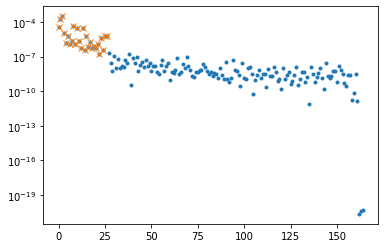

In [92]:
plt.semilogy(np.abs(bm_sat),'.')
plt.semilogy(np.abs(bm_sat_reg),'x')

In [17]:
Fz2bm = np.linalg.pinv(bm2Fz_oa)
bm_sat = BM_[1][0,:,4]

while (any(max_Fz < bm2Fz_oa.dot(bm_sat)) or any(-max_Fz > bm2Fz_oa.dot(bm_sat))):
    print(max_Fz, max(bm2Fz_oa.dot(bm_sat)))
    print(-max_Fz, min(bm2Fz_oa.dot(bm_sat)))
    bm_sat = Fz2bm.dot(np.clip(bm2Fz_oa.dot(bm_sat),
                            -np.array([max_Fz]*bm2Fz_oa.shape[0]),
                            np.array([max_Fz]*bm2Fz_oa.shape[0])))



147 172.9410106583431
-147 -211.1364294778381
147 160.85400194782318
-147 -190.23604606084237
147 155.15098163900768
-147 -178.94421592335163
147 152.11195142372947
-147 -172.09648417191852
147 150.5268014935105
-147 -167.42273270474598
147 149.4504204233079
-147 -163.88932799718154
147 148.70044055785854
-147 -160.99583843629722
147 148.1843259167992
-147 -158.6202929959231
147 147.80974528727955
-147 -156.65887134590656
147 147.53315765199898
-147 -155.0355851484144
147 147.33113275381794
-147 -153.69115266458206
147 147.18555663236302
-147 -152.57682594141528
147 147.08246577440522
-147 -151.65249863054015
147 147.01113092949709
-147 -150.88515675980705
147 146.96333804585498
-147 -150.24760982446676
147 146.92591722106187
-147 -149.7171997909458
147 146.89527998628998
-147 -149.27554102006278
147 146.87020404612684
-147 -148.90750753213678
147 146.84968647516655
-147 -148.60058620896888
147 146.8329044490094
-147 -148.3444211035303
147 146.8191829926593
-147 -148.13043775658417
147